In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib notebook

In [42]:
data_X = pd.read_csv('weather.csv')
data_X.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
data_X.shape

(142193, 24)

In [4]:
data_X.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [5]:
data_Y = data_X.RainTomorrow.replace({'No':0, 'Yes': 1})
del data_X['RainTomorrow']
del data_X['Unnamed: 0']

### Реализация логистической регрессии

In [7]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])
y_signed = np.array([1, 1, -1, -1])

__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [8]:
def probability(theta, X):    
    result = 1/(1+np.exp(-(np.dot(X, theta))))
    return result

prob = probability(theta, X)
assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [10]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = (prob < threshold).astype(int)
    return result


y_pred = binary_class_prediction(theta, X)

assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

In [11]:
def logloss(theta, X, y): 
    log = np.log(1 + np.exp(-y*(np.dot(X, theta)))) 
    result = np.average(log)
    return result


assert logloss(theta, X, y_signed).round(3) == 0.861, 'Функция считается неверно'

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

In [12]:
def gradient(theta, X, y):
    grad_all = (-y/(1+np.exp(-y*(np.dot(X, theta)))) * np.exp(-y*(np.dot(X, theta))) * X.T).T
    result = np.average(grad_all, axis = 0)
    return result 

assert gradient(theta, X, y_signed).shape == theta.shape, 'Неверный размер массива'

In [106]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(8, 6))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('iterations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [20]:
X, y = make_classification(n_samples=2000)

<IPython.core.display.Javascript object>


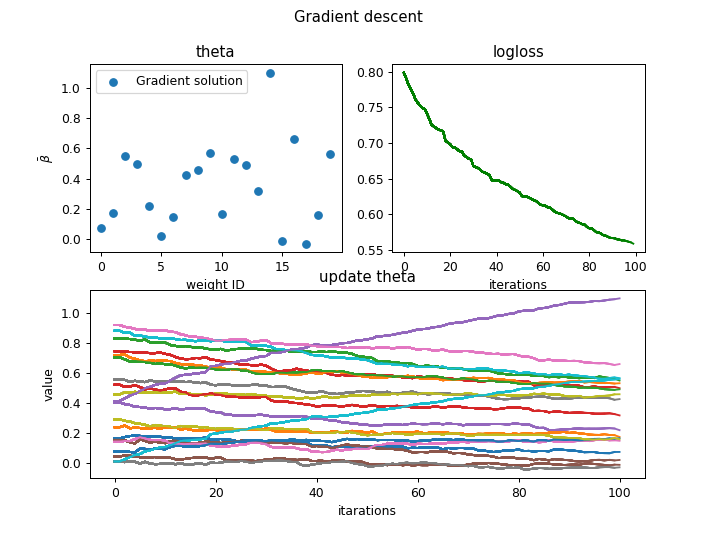

In [22]:
optimal_theta = fit(X, y, plot = True)

In [107]:
# Собираем всё вместе

class MyLogisticRegression:
    
    
    def probability(self, X):    
        result = 1/(1+np.exp(-(np.dot(X, self.theta))))
        return result


    def binary_class_prediction(self, X, threshold =.5):
        prob =  self.probability(X)
        result = (prob < threshold).astype(int)
        return result
    
    
    def logloss(self, X, y): 
        log = np.log(1 + np.exp(-y*(np.dot(X, self.theta)))) 
        result = np.average(log)
        return result


    def _gradient(self, X, y):
        grad_all = (-y/(1+np.exp(-y*(np.dot(X, self.theta)))) * np.exp(-y*(np.dot(X, self.theta))) * X.T).T
        result = np.average(grad_all, axis = 0)
        return result 
    
    
    def fit(self, X, y, batch_size=10, h=0.05,  iters=100, plot=False):

        size, dim = X.shape
        self.theta = np.random.uniform(size=dim)

        errors = []
        theta_history = self.theta
        colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]

        # plt 
        if plot:
            fig = plt.figure(figsize=(8, 6))
            ax1 = fig.add_subplot(221)
            ax2 = fig.add_subplot(222)
            ax3 = fig.add_subplot(212)
            fig.suptitle('Gradient descent')


        for i in range(iters):  
            
            print ('%-3s%%' % round((i+1)*(iters/100), 1), end="\r" )
            # берём случайный набор элементов
            batch = np.random.choice(size, batch_size, replace=False)
            X_batch = X.iloc[batch]
            y_batch = y.iloc[batch]

            # считаем производные
            grad = self._gradient(X_batch, y_batch)

            assert type(grad) == np.ndarray, 'неверный тип'
            assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
            assert grad.shape[0] == len(self.theta), 'длина вектора должна быть равной количеству весов'


            # Обновляем веса
            self.theta -= grad * h
            theta_history = np.vstack((theta_history, self.theta))

            # error
            loss = self.logloss(X, y)
            errors.append(loss)

            if plot:
                ax1.clear()            
                ax1.scatter(range(dim), self.theta, label='Gradient solution')
                ax1.legend(loc="upper left")
                ax1.set_title('theta')
                ax1.set_ylabel(r'$\bar \beta$')
                ax1.set_xlabel('weight ID')

                ax2.plot(range(_+1), errors, 'g-')
                ax2.set_title('logloss')
                ax2.set_xlabel('iterations')

                ax3.plot(theta_history)
                ax3.set_title('update theta')
                ax3.set_ylabel('value')
                ax3.set_xlabel('itarations')
                time.sleep(0.05)
                fig.canvas.draw()   

        print ("Done  " , end="\r" )

## 1. MyLogisticRegression

In [102]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.25, random_state=10)

In [103]:
# Количество пропущенных значений в столбиках
X_train.isnull().sum()[X_train.isnull().sum()>0]

MinTemp            467
MaxTemp            245
Rainfall          1072
Evaporation      45704
Sunshine         50970
WindGustDir       7025
WindGustSpeed     6983
WindDir9am        7509
WindDir3pm        2842
WindSpeed9am      1015
WindSpeed3pm      1979
Humidity9am       1314
Humidity3pm       2693
Pressure9am      10513
Pressure3pm      10499
Cloud9am         40209
Cloud3pm         42855
Temp9am            667
Temp3pm           2040
RainToday         1072
dtype: int64

In [104]:
# Обработка числовых пропусков: заполняем средними значениями  

numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

# Оставшиеся пустые категориальные признаки
X_train.isnull().sum()[X_train.isnull().sum()>0]

WindGustDir    7025
WindDir9am     7509
WindDir3pm     2842
RainToday      1072
dtype: int64

In [108]:
%%time
model = MyLogisticRegression()
model.fit(X_train[numeric_features], y_train)

data_test_predict_numeric = model.binary_class_prediction(X_test[numeric_features])
data_train_predict_numeric = model.binary_class_prediction(X_train[numeric_features])

CPU times: user 24.1 s, sys: 2.82 s, total: 26.9 s
Wall time: 7.5 s


In [109]:
print ("MyLogisticRegression:\n")

print ("Обучение с использованием числовых признаков:")
print ("time = 9.47 s")
print("Test MAE = %.4f" % mean_absolute_error(y_test, data_test_predict_numeric))
print("Train MAE = %.4f" % mean_absolute_error(y_train, data_train_predict_numeric))

print("Test Accuracy = %.4f" % np.mean(data_test_predict_numeric == y_test))

MyLogisticRegression:

Обучение с использованием числовых признаков:
time = 9.47 s
Test MAE = 0.2235
Train MAE = 0.2244
Test Accuracy = 0.7765


## 2. LogisticRegression

In [110]:
from sklearn.linear_model import LogisticRegression

In [167]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.25, random_state=10)

### 1) Числовые признаки

In [168]:
# Обработка числовых пропусков

numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [169]:
%%time
model = LogisticRegression()
model.fit(X_train[numeric_features], y_train)

data_test_predict_numeric = model.predict(X_test[numeric_features])
data_train_predict_numeric = model.predict(X_train[numeric_features])

CPU times: user 19.2 s, sys: 1.85 s, total: 21 s
Wall time: 5.95 s


### 2) Числовые признаки + масштабирование

In [114]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

In [115]:
%%time
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

data_test_predict_scaled = model.predict(X_test_scaled)
data_train_predict_scaled = model.predict(X_train_scaled)

CPU times: user 5.59 s, sys: 575 ms, total: 6.16 s
Wall time: 1.82 s


### 3) Числовые масштабированные + категориальные признаки

In [170]:
# Заполняем пропуски и кодируем категориальные значения

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("Unknown")
X_test[categorical] = X_test[categorical].fillna("Unknown")

numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

In [171]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('encoding+scaling', column_transformer),
    ('regression', LogisticRegression())
])

In [172]:
%%time
model = pipeline.fit(X_train, y_train)

data_test_predict_encoded = model.predict(X_test)
data_train_predict_encoded = model.predict(X_train)

CPU times: user 5.14 s, sys: 139 ms, total: 5.28 s
Wall time: 5.34 s


In [119]:
print ("LogisticRegression:")

print ("\nОбучение с использованием числовых признаков:")
print("Test MAE = %.4f" % mean_absolute_error(y_test, data_test_predict_numeric))
print("Train MAE = %.4f" % mean_absolute_error(y_train, data_train_predict_numeric))
print("Accuracy = %.4f" % np.mean(data_test_predict_numeric == y_test))

print ("\nОбучение с использованием масштабированных числовых признаков:")
print("Test MAE = %.4f" % mean_absolute_error(y_test, data_test_predict_scaled))
print("Train MAE = %.4f" % mean_absolute_error(y_train, data_train_predict_scaled))
print("Accuracy = %.4f" % np.mean(data_test_predict_scaled == y_test))

print ("\nОбучение с использованием масштабированных числовых и кодированных категориальных признаков:")
print("Test MAE = %.4f" % mean_absolute_error(y_test, data_test_predict_encoded))
print("Train MAE = %.4f" % mean_absolute_error(y_train, data_train_predict_encoded))
print("Accuracy = %.4f" % np.mean(data_test_predict_encoded == y_test))

LogisticRegression:

Обучение с использованием числовых признаков:
Test MAE = 0.1628
Train MAE = 0.1628
Accuracy = 0.8372

Обучение с использованием масштабированных числовых признаков:
Test MAE = 0.1585
Train MAE = 0.1586
Accuracy = 0.8415

Обучение с использованием масштабированных числовых и кодированных категориальных признаков:
Test MAE = 0.0000
Train MAE = 0.0000
Accuracy = 1.0000


In [ ]:
# o_O

## 3. KNeighborsClassifier

In [120]:
from sklearn.neighbors import KNeighborsClassifier

In [121]:
data_X = pd.read_csv('weather.csv')
small_data_X = data_X.sample(frac=0.05, replace=True, random_state=1)

In [122]:
small_data_Y = small_data_X.RainTomorrow.replace({'No':0, 'Yes': 1})
del small_data_X['RainTomorrow']
del small_data_X['Unnamed: 0']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(small_data_X, small_data_Y, test_size=0.25, random_state=10)

In [124]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)[numeric_features]
X_test = X_test.fillna(numeric_data_mean)[numeric_features]

In [125]:
from matplotlib import gridspec
from sklearn.metrics import classification_report

accuracy = []
for n_neighbors in (range(1, 26, 2)):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    accuracy.append( np.mean(model.predict(X_test) == y_test)) 

<IPython.core.display.Javascript object>


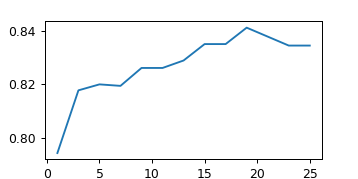

In [126]:
fig = plt.figure(figsize=(4, 2))
plt.plot(range(1, 26, 2), accuracy)  

In [137]:
# Оптимальное количество соседей
n_neighbors = 19
model = KNeighborsClassifier(n_neighbors=n_neighbors)
model.fit(X_train, y_train)

accuracy_knn = np.mean(model.predict(X_test) == y_test) 
    
print('_'*30)
print(f'k={n_neighbors}')
print(classification_report(y_test, model.predict(X_test)))

______________________________
k=19
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1375
           1       0.74      0.46      0.57       403

    accuracy                           0.84      1778
   macro avg       0.80      0.71      0.73      1778
weighted avg       0.83      0.84      0.83      1778



### К взвешенных ближайших соседей

In [139]:
def linear_weights(distance):
    k = distance.shape[1]
    return ((k - np.arange(0, k))/k) * np.ones_like(distance)

<IPython.core.display.Javascript object>


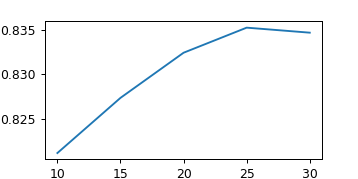

In [143]:
accuracy = []
for n_neighbors in (range(10, 35, 5)):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=linear_weights)
    model.fit(X_train, y_train)
    accuracy.append( np.mean(model.predict(X_test) == y_test)) 
    
fig = plt.figure(figsize=(4, 2))
plt.plot(range(10, 35, 5), accuracy)      

In [180]:
# Оптимальное количество соседей
n_neighbors = 25
model = KNeighborsClassifier(n_neighbors=n_neighbors)
model.fit(X_train, y_train)

accuracy_knn_weight = np.mean(model.predict(X_test) == y_test) 
    
print('_'*30)
print(f'k={n_neighbors}')
print(classification_report(y_test, model.predict(X_test)))

CPU times: user 1.23 s, sys: 366 ms, total: 1.6 s
Wall time: 855 ms


0.13104611923509563

### К-ближайших соседей + окно Парзена

In [146]:
def K(distance, h):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

<IPython.core.display.Javascript object>


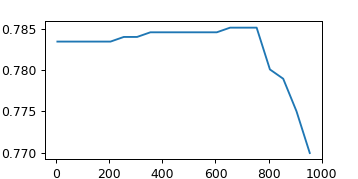

In [151]:
accuracy = []
for h in (range(5, 1000, 50)):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=lambda x: K(x, h=h/100))
    model.fit(X_train, y_train)
    accuracy.append( np.mean(model.predict(X_test) == y_test)) 
    
fig = plt.figure(figsize=(4, 2))
plt.plot(range(5, 1000, 50), accuracy)  

In [153]:
h = 7.6
model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=lambda x: K(x, h=h))
model.fit(X_train, y_train)

accuracy_knn_Parzen = np.mean(model.predict(X_test) == y_test) 
    
print('_'*30)
print(f'k={n_neighbors}')
print(classification_report(y_test, model.predict(X_test)))

______________________________
k=30
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1375
           1       0.83      0.06      0.12       403

    accuracy                           0.78      1778
   macro avg       0.81      0.53      0.50      1778
weighted avg       0.79      0.78      0.70      1778



In [156]:
print ("KNeighborsClassifier:\n")

print ("K ближайших соседей:  Accuracy = %.4f" % accuracy_knn)
print ("K взвешенных ближайших соседей:  Accuracy = %.4f" % accuracy_knn_weight)
print ("K ближайших соседей + Парзен:  Accuracy = %.4f" % accuracy_knn_Parzen)

KNeighborsClassifier:

K ближайших соседей:  Accuracy = 0.8414
K взвешенных ближайших соседей:  Accuracy = 0.8346
K ближайших соседей + Парзен:  Accuracy = 0.7846


## 4. Naive Bayes¶

In [157]:
from sklearn.naive_bayes import GaussianNB

In [174]:
X_train, X_test, y_train, y_test = train_test_split(small_data_X, small_data_Y, test_size=0.25, random_state=10)

In [175]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)[numeric_features]
X_test = X_test.fillna(numeric_data_mean)[numeric_features]

In [176]:
%%time
model = GaussianNB()
data_test_predict_NB = model.fit(X_train, y_train).predict(X_test)
data_train_predict_NB = model.fit(X_train, y_train).predict(X_train)

CPU times: user 48.8 ms, sys: 4.92 ms, total: 53.7 ms
Wall time: 49.8 ms


In [165]:
print ("\nОбучение с использованием числовых признаков:")
print("Test MAE = %.4f" % mean_absolute_error(y_test, data_test_predict_NB))
print("Train MAE = %.4f" % mean_absolute_error(y_train, data_train_predict_NB))
print("Accuracy = %.4f" % np.mean(data_test_predict_NB == y_test))


Обучение с использованием числовых признаков:
Test MAE = 0.1952
Train MAE = 0.1862
Accuracy = 0.8048


### Сравнение алгоритмов

In [182]:
# Рассмотрим лучшие реализации каждого алгоритма

results = [['MyLogisticRegression', 0.7765, 9.47],
           ['LogisticRegression', 1, 5.34],
           ['KNeighborsClassifier', 0.8414, 0.855],
           ['Naive Bayes', 0.8048, 0.498]]

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Time (s)'])
results_df


# Наивный байесовский классификатор показывает лучшую скорость и хорошую точность.
# Метод ближайших соседей работает за приемлемое время при достаточно небольшом размере выборки. 
# При правильно подобранном k результаты достаточно точные.
# Логистическая регрессия работает в несколько раз дольше, но на данной выборке оказалась точнее.

,Model,Accuracy,Time (s)
0,MyLogisticRegression,0.7765,9.470
1,LogisticRegression,1.0000,5.340
2,KNeighborsClassifier,0.8414,0.855
3,Naive Bayes,0.8048,0.498
